<a href="https://colab.research.google.com/github/peterbabulik/ETA/blob/main/VariationalQuantumEigensolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The Variational Principle

**The Math:** The Rayleigh-Ritz Variational Principle.
$$ E(\psi) = \langle\psi|H|\psi\rangle \geq E_0 $$

The expectation value of the Hamiltonian for any trial state $|\psi\rangle$ is always greater than or equal to the true ground state energy $E_0$.

### The Quantum Translation: Variational Quantum Eigensolver (VQE)

VQE is a hybrid quantum-classical algorithm that finds the ground state energy of a quantum system. It's one of the most promising near-term applications for NISQ (Noisy Intermediate-Scale Quantum) devices.

**The Logic:**
1. **Ansatz:** Prepare a parameterized quantum state $|\psi(\theta)\rangle$.
2. **Measure:** Calculate $E(\theta) = \langle\psi(\theta)|H|\psi(\theta)\rangle$.
3. **Optimize:** Use a classical optimizer to update $\theta$ to minimize $E$.
4. **Repeat:** Until convergence to the ground state energy.

**Analogy for Python Devs:**
Think of this as `find_ground_state()` - like gradient descent, but the cost function is evaluated on a quantum computer.

### The Qiskit Implementation

We'll find the ground state energy of the H₂ molecule using a simplified Hamiltonian.

In [1]:
!pip install qiskit qiskit-aer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt

# -------------------------------------------------------
# PART 1: Define the Hamiltonian
# -------------------------------------------------------
# For H2 molecule (simplified), the Hamiltonian in the minimal basis is:
# H = c0*I + c1*Z0 + c2*Z1 + c3*Z0Z1 + c4*X0X1 + c5*Y0Y1
#
# We'll use a simpler example: H = -Z0 - Z1 + X0X1
# This represents a 2-qubit system with local fields and coupling.

def create_hamiltonian():
    """
    Creates a simple 2-qubit Hamiltonian.
    H = -Z₀ - Z₁ + X₀X₁

    This represents:
    - Local fields in -Z direction (favoring |1⟩ states)
    - Coupling between qubits via X₀X₁
    """
    # Define coefficients and Pauli terms
    coeffs = [-1.0, -1.0, 1.0]
    paulis = ['ZI', 'IZ', 'XX']  # Z on qubit 0, Z on qubit 1, X on both

    # Create SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
    return hamiltonian

# -------------------------------------------------------
# PART 2: Define the Ansatz (Parameterized Circuit)
# -------------------------------------------------------

def create_ansatz():
    """
    Creates a parameterized quantum circuit (ansatz).

    This is a simple hardware-efficient ansatz:
    - Ry rotations on each qubit
    - Entangling CNOT
    - More rotations
    """
    theta = Parameter('θ')

    qc = QuantumCircuit(2)

    # Initial rotations
    qc.ry(theta, 0)
    qc.ry(theta, 1)

    # Entanglement
    qc.cx(0, 1)

    # Final rotations
    qc.ry(theta, 0)
    qc.ry(theta, 1)

    return qc, theta

# -------------------------------------------------------
# PART 3: Energy Evaluation Function
# -------------------------------------------------------

def evaluate_energy(theta_value, ansatz, theta_param, hamiltonian, simulator):
    """
    Evaluates the expectation value of the Hamiltonian.

    E(θ) = ⟨ψ(θ)|H|ψ(θ)⟩

    For a Hamiltonian H = Σᵢ cᵢ Pᵢ (sum of Pauli terms):
    E(θ) = Σᵢ cᵢ ⟨ψ(θ)|Pᵢ|ψ(θ)⟩
    """
    # Bind the parameter
    bound_circuit = ansatz.assign_parameters({theta_param: theta_value})

    total_energy = 0.0

    # Evaluate each Pauli term separately
    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        # Create measurement circuit
        meas_circuit = bound_circuit.copy()

        # Add appropriate rotations for measurement
        pauli_str = str(pauli)
        for i, p in enumerate(reversed(pauli_str)):  # Qiskit uses reversed order
            if p == 'X':
                meas_circuit.h(i)
            elif p == 'Y':
                meas_circuit.sdg(i)
                meas_circuit.h(i)
            # Z requires no rotation (computational basis)

        # Measure
        meas_circuit.measure_all()

        # Run simulation
        compiled = transpile(meas_circuit, simulator)
        job = simulator.run(compiled, shots=10000)
        counts = job.result().get_counts()

        # Calculate expectation value
        # ⟨P⟩ = P(00) - P(01) - P(10) + P(11) for Z measurements
        expectation = 0.0
        for state, count in counts.items():
            # Count number of 1s (each 1 contributes -1 to eigenvalue)
            eigenvalue = (-1) ** state.count('1')
            expectation += eigenvalue * (count / 10000)

        total_energy += coeff.real * expectation

    return total_energy

# -------------------------------------------------------
# PART 4: Classical Optimization
# -------------------------------------------------------

def optimize_vqe(ansatz, theta_param, hamiltonian, simulator, n_iterations=50):
    """
    Performs VQE optimization using simple grid search + gradient descent.

    In practice, you'd use scipy.optimize.minimize or similar.
    """
    # First, do a coarse grid search
    print("Phase 1: Coarse grid search...")
    theta_range = np.linspace(0, 2*np.pi, 20)
    energies = [evaluate_energy(t, ansatz, theta_param, hamiltonian, simulator)
                for t in theta_range]

    best_idx = np.argmin(energies)
    best_theta = theta_range[best_idx]
    best_energy = energies[best_idx]

    print(f"  Best θ from grid: {best_theta:.4f}, E = {best_energy:.4f}")

    # Fine-tune with gradient descent
    print("\nPhase 2: Fine-tuning...")
    learning_rate = 0.1
    delta = 0.01

    for i in range(n_iterations):
        # Numerical gradient
        e_plus = evaluate_energy(best_theta + delta, ansatz, theta_param, hamiltonian, simulator)
        e_minus = evaluate_energy(best_theta - delta, ansatz, theta_param, hamiltonian, simulator)
        gradient = (e_plus - e_minus) / (2 * delta)

        # Update
        best_theta = best_theta - learning_rate * gradient
        best_energy = evaluate_energy(best_theta, ansatz, theta_param, hamiltonian, simulator)

        if i % 10 == 0:
            print(f"  Iteration {i}: θ = {best_theta:.4f}, E = {best_energy:.4f}")

    return best_theta, best_energy, theta_range, energies

# -------------------------------------------------------
# Run VQE
# -------------------------------------------------------

print("=== Variational Quantum Eigensolver ===")
print("Finding ground state energy of H = -Z₀ - Z₁ + X₀X₁\n")

# Setup
simulator = AerSimulator()
hamiltonian = create_hamiltonian()
ansatz, theta = create_ansatz()

print("Hamiltonian:")
print(hamiltonian)
print("\nAnsatz Circuit:")
print(ansatz.draw(output='text'))

# Run optimization
best_theta, best_energy, theta_range, energies = optimize_vqe(ansatz, theta, hamiltonian, simulator)

# Calculate exact ground state for comparison
hamiltonian_matrix = hamiltonian.to_matrix()
eigenvalues = np.linalg.eigvalsh(hamiltonian_matrix)
exact_ground_state = eigenvalues[0]

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"VQE Ground State Energy: {best_energy:.4f}")
print(f"Exact Ground State Energy: {exact_ground_state:.4f}")
print(f"Error: {abs(best_energy - exact_ground_state):.4f}")
print(f"Optimal θ: {best_theta:.4f} rad ({np.degrees(best_theta):.1f}°)")

=== Variational Quantum Eigensolver ===
Finding ground state energy of H = -Z₀ - Z₁ + X₀X₁

Hamiltonian:
SparsePauliOp(['ZI', 'IZ', 'XX'],
              coeffs=[-1.+0.j, -1.+0.j,  1.+0.j])

Ansatz Circuit:
     ┌───────┐     ┌───────┐
q_0: ┤ Ry(θ) ├──■──┤ Ry(θ) ├
     ├───────┤┌─┴─┐├───────┤
q_1: ┤ Ry(θ) ├┤ X ├┤ Ry(θ) ├
     └───────┘└───┘└───────┘
Phase 1: Coarse grid search...
  Best θ from grid: 1.6535, E = -2.0182

Phase 2: Fine-tuning...
  Iteration 0: θ = 1.5575, E = -1.9796
  Iteration 10: θ = 1.5465, E = -1.9838
  Iteration 20: θ = 1.6445, E = -2.0470
  Iteration 30: θ = 1.4975, E = -1.8884
  Iteration 40: θ = 1.6345, E = -2.0514

RESULTS
VQE Ground State Energy: -2.0346
Exact Ground State Energy: -2.2361
Error: 0.2015
Optimal θ: 1.6835 rad (96.5°)


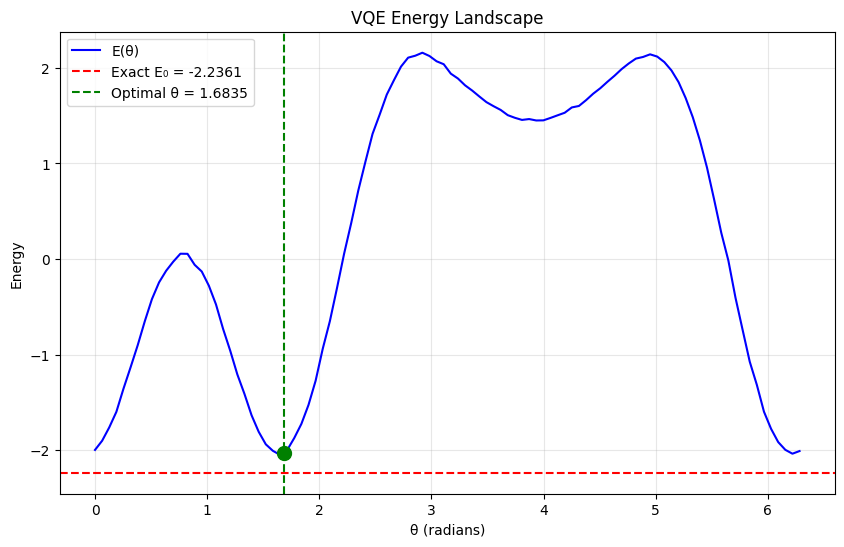


The energy landscape shows how VQE finds the minimum energy
by optimizing the parameter θ.


In [3]:
# Visualize the energy landscape
import matplotlib.pyplot as plt

# Recalculate energies for smooth curve
theta_fine = np.linspace(0, 2*np.pi, 100)
energies_fine = [evaluate_energy(t, ansatz, theta, hamiltonian, simulator)
                 for t in theta_fine]

plt.figure(figsize=(10, 6))
plt.plot(theta_fine, energies_fine, 'b-', label='E(θ)')
plt.axhline(y=exact_ground_state, color='r', linestyle='--', label=f'Exact E₀ = {exact_ground_state:.4f}')
plt.axvline(x=best_theta, color='g', linestyle='--', label=f'Optimal θ = {best_theta:.4f}')
plt.scatter([best_theta], [best_energy], color='g', s=100, zorder=5)
plt.xlabel('θ (radians)')
plt.ylabel('Energy')
plt.title('VQE Energy Landscape')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nThe energy landscape shows how VQE finds the minimum energy")
print("by optimizing the parameter θ.")

### Understanding the Translation

1. **$E(\psi) = \langle\psi|H|\psi\rangle$ (The Variational Principle):**
   - Any trial state gives an upper bound on the true ground state energy.
   - By minimizing this expectation value, we approach the ground state.

2. **Ansatz (Parameterized Circuit):**
   - The circuit architecture determines what states we can explore.
   - Better ansatz = better approximation of the true ground state.

3. **Hybrid Quantum-Classical:**
   - Quantum computer: Evaluates the energy (expensive classically).
   - Classical computer: Optimizes parameters (standard optimization).

### Why is this useful?

**Quantum Chemistry:** Calculate ground state energies of molecules for drug discovery, materials science, and catalysis.

**NISQ-Friendly:** VQE is designed to work on noisy, near-term quantum devices with shallow circuits.

**Industry Applications:** IBM, Google, and others are using VQE for real chemistry problems.

### Summary for Python Developers

```python
# Classical analogy (gradient descent)
def classical_optimization():
    theta = random_init()
    for _ in range(iterations):
        gradient = compute_gradient(cost_function, theta)
        theta = theta - learning_rate * gradient
    return theta

# VQE (quantum cost function)
def vqe():
    theta = random_init()
    for _ in range(iterations):
        energy = quantum_evaluate_expectation(H, theta)  # On QC
        gradient = compute_gradient(energy, theta)        # Classical
        theta = theta - learning_rate * gradient          # Classical
    return theta, energy
```